In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np
import matplotlib.pyplot as plt
import os
import time
#from esbn_pytorch import ESBN

In [2]:
from util import log
from modules import *

In [3]:
class Encoder_conv(nn.Module):
	#def __init__(self, args):
	def __init__(self):
		super(Encoder_conv, self).__init__()
		log.info('Building convolutional encoder...')
		# Convolutional layers
		log.info('Conv layers...')
		'''
		self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(32, 32, 4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(32, 32, 4, stride=2, padding=1)
		'''
		self.conv1 = nn.Conv2d(1, 160, 4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(160, 160, 4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(160, 160, 4, stride=2, padding=1)
		# Fully-connected layers
		log.info('FC layers...')
		#self.fc1 = nn.Linear(4*4*32, 256)
		#self.fc2 = nn.Linear(256, 128)
		self.fc1 = nn.Linear(64000, 256)
		self.fc2 = nn.Linear(256, 128)
		# Nonlinearities
		self.relu = nn.ReLU()
		# Initialize parameters
		for name, param in self.named_parameters():
			# Initialize all biases to 0
			if 'bias' in name:
				nn.init.constant_(param, 0.0)
			# Initialize all pre-ReLU weights using Kaiming normal distribution
			elif 'weight' in name:
				nn.init.kaiming_normal_(param, nonlinearity='relu')
	def forward(self, x):
		# Convolutional layers
		conv1_out = self.relu(self.conv1(x))
		conv2_out = self.relu(self.conv2(conv1_out))
		conv3_out = self.relu(self.conv3(conv2_out))
		# Flatten output of conv. net
		conv3_out_flat = torch.flatten(conv3_out, 1)
		# Fully-connected layers
		#print("conv3_out_flat.size() =",conv3_out_flat.size())
		#time.sleep(120)
		fc1_out = self.relu(self.fc1(conv3_out_flat))
		fc2_out = self.relu(self.fc2(fc1_out))
		# Output
		z = fc2_out
		return z

In [4]:
class Model(nn.Module):
	#def __init__(self, task_gen, args):
	def __init__(self):
		super(Model, self).__init__()
		# Encoder
		log.info('Building encoder...')
		'''
		if args.encoder == 'conv':
			self.encoder = Encoder_conv(args)
		elif args.encoder == 'mlp':
			self.encoder = Encoder_mlp(args)
		elif args.encoder == 'rand':
			self.encoder = Encoder_rand(args)
		'''
		self.encoder = Encoder_conv()# removed "args" argument
		# LSTM and output layers
		log.info('Building LSTM and output layers...')
		self.z_size = 128
		self.key_size = 256
		self.hidden_size = 512
		self.lstm = nn.LSTM(self.key_size + 1, self.hidden_size, batch_first=True)
		self.key_w_out = nn.Linear(self.hidden_size, self.key_size)
		self.g_out = nn.Linear(self.hidden_size, 1)
		self.confidence_gain = nn.Parameter(torch.ones(1))
		self.confidence_bias = nn.Parameter(torch.zeros(1))
		#self.y_out = nn.Linear(self.hidden_size, task_gen.y_dim)
		y_out = 8 # number of outputs/ ESBN = 4
		self.y_out = nn.Linear(self.hidden_size, y_out)
		# Context normalization
		#if args.norm_type == 'contextnorm' or args.norm_type == 'tasksegmented_contextnorm':
		if True: # assumes "contextnorm or tasksegmented_contextnorm"
			self.contextnorm = True
			self.gamma = nn.Parameter(torch.ones(self.z_size))
			self.beta = nn.Parameter(torch.zeros(self.z_size))
		else:
			self.contextnorm = False
		'''
		if args.norm_type == 'tasksegmented_contextnorm':
			self.task_seg = task_gen.task_seg
		else:
			self.task_seg = [np.arange(task_gen.seq_len)]
		'''
		seq_len = 16 # number of images per Raven problem / ESBN = 9        
		self.task_seg = [np.arange(seq_len)]
		# Nonlinearities
		self.relu = nn.ReLU()
		self.sigmoid = nn.Sigmoid()
		self.softmax = nn.Softmax(dim=1)
		# Initialize parameters
		for name, param in self.named_parameters():
			# Encoder parameters have already been initialized
			if not ('encoder' in name) and not ('confidence' in name):
				# Initialize all biases to 0
				if 'bias' in name:
					nn.init.constant_(param, 0.0)
				else:
					if 'lstm' in name:
						# Initialize gate weights (followed by sigmoid) using Xavier normal distribution
						nn.init.xavier_normal_(param[:self.hidden_size*2,:])
						nn.init.xavier_normal_(param[self.hidden_size*3:,:])
						# Initialize input->hidden and hidden->hidden weights (followed by tanh) using Xavier normal distribution with gain = 
						nn.init.xavier_normal_(param[self.hidden_size*2:self.hidden_size*3,:], gain=5.0/3.0)
					elif 'key_w' in name:
						# Initialize weights for key output layer (followed by ReLU) using Kaiming normal distribution
						nn.init.kaiming_normal_(param, nonlinearity='relu')
					elif 'g_out' in name:
						# Initialize weights for gate output layer (followed by sigmoid) using Xavier normal distribution
						nn.init.xavier_normal_(param)
					elif 'y_out' in name:
						# Initialize weights for multiple-choice output layer (followed by softmax) using Xavier normal distribution
						nn.init.xavier_normal_(param)
	def forward(self, x_seq, device):
		# Encode all images in sequence
		z_seq = []
		for t in range(x_seq.shape[1]):
			x_t = x_seq[:,t,:,:].unsqueeze(1)
			z_t = self.encoder(x_t)
			z_seq.append(z_t)
		z_seq = torch.stack(z_seq, dim=1)
		if self.contextnorm:
			z_seq_all_seg = []
			for seg in range(len(self.task_seg)):
				z_seq_all_seg.append(self.apply_context_norm(z_seq[:,self.task_seg[seg],:]))
			z_seq = torch.cat(z_seq_all_seg, dim=1)
		# Initialize hidden state
		hidden = torch.zeros(1, x_seq.shape[0], self.hidden_size).to(device)
		cell_state = torch.zeros(1, x_seq.shape[0], self.hidden_size).to(device)
		# Initialize retrieved key vector
		key_r = torch.zeros(x_seq.shape[0], 1, self.key_size + 1).to(device)
		# Memory model (extra time step to process key retrieved on final time step)
		for t in range(x_seq.shape[1] + 1):
			# Image embedding
			if t == x_seq.shape[1]:
				z_t = torch.zeros(x_seq.shape[0], 1, self.z_size).to(device)
			else:
				z_t = z_seq[:,t,:].unsqueeze(1)
			# Controller
			# LSTM
			lstm_out, (hidden, cell_state) = self.lstm(key_r, (hidden, cell_state))
			# Key output layers
			key_w = self.relu(self.key_w_out(lstm_out))
			# Gates
			g = self.sigmoid(self.g_out(lstm_out))
			# Task output layer
			y_pred_linear = self.y_out(lstm_out).squeeze()
			y_pred = y_pred_linear.argmax(1)
			# Read from memory
			if t == 0:
				key_r = torch.zeros(x_seq.shape[0], 1, self.key_size + 1).to(device)
			else:
				# Read key
				w_k = self.softmax((z_t * M_v).sum(dim=2))
				c_k = self.sigmoid(((z_t * M_v).sum(dim=2) * self.confidence_gain) + self.confidence_bias)
				key_r = g * (torch.cat([M_k, c_k.unsqueeze(2)], dim=2) * w_k.unsqueeze(2)).sum(1).unsqueeze(1)
			# Write to memory
			if t == 0:
				M_k = key_w
				M_v = z_t
			else:
				M_k = torch.cat([M_k, key_w], dim=1)
				M_v = torch.cat([M_v, z_t], dim=1)
		return y_pred_linear, y_pred
	def apply_context_norm(self, z_seq):
		eps = 1e-8
		z_mu = z_seq.mean(1)
		z_sigma = (z_seq.var(1) + eps).sqrt()
		z_seq = (z_seq - z_mu.unsqueeze(1)) / z_sigma.unsqueeze(1)
		z_seq = (z_seq * self.gamma) + self.beta
		return z_seq

In [5]:
def grab_npz_img(img_path):
    data = np.load(img_path)
    img = data['image']
    target = data['target']
    x = img[:,:,:]
    #x = np.expand_dims(x, axis=0)
    #x = x.reshape((x.shape[0],x.shape[1],x.shape[2],x.shape[3],1))
    return x

In [6]:
def grab_npz_target(target_path):
    data = np.load(target_path)
    target = data['target']
    y = int(target)
    return y

In [7]:
def create_dataset(folder,num_imgs,config):
    X = []
    #X = np.array(X)
    Y =[]
    #for i in range(num_imgs):
    name = ''
    if config=='train':
        name = 'train'
    elif config=='validate':
        name = 'val'
    else:
        name = 'test'
        
    count = 0
    i = 0
    while count < num_imgs:
        try:
            x = grab_npz_img('/home/asw3x/RAVEN-10000/'+folder+'/RAVEN_%d_%s.npz'%(i,name))
            y = grab_npz_target('/home/asw3x/RAVEN-10000/'+folder+'/RAVEN_%d_%s.npz'%(i,name))
            i += 1
        except:
            i += 1
            continue
        X.append(x)
        #X = np.concatenate(x)
        Y.append(y)
        count += 1
    X = np.array(X)
    X = np.squeeze(X)
    #X = np.expand_dims(X, axis=4)
    #X = X.reshape((X.shape[0],X.shape[2],X.shape[3],X.shape[1]))
    #X = np.moveaxis(X, 1, -1)
    return X,np.array(Y)

In [8]:
def create_task(size=1000, task="center_single"):
    folder = task
    train_size = size
    test_size = train_size*0.4
    
    X_train, Y_train = create_dataset(folder,train_size,"train")
    X_test, Y_test = create_dataset(folder,test_size,"test")
    
    # Create training and test sets
    train_set = {'img_seq': X_train, 'y': Y_train}
    test_set = {'img_seq': X_test, 'y': Y_test}
    return train_set, test_set

In [9]:
training_set,test_set = create_task()

In [10]:
training_set['img_seq'].shape

(1000, 16, 160, 160)

In [11]:
training_set['y'].shape

(1000,)

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        '''
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        '''
        self.img_seq = dataset['img_seq']
        self.y = dataset['y']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        '''
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        '''
        img_seq = self.img_seq[idx,:,:,:]
        y = self.y[idx]
        
        return img_seq, y

In [13]:
training_set = CustomImageDataset(training_set)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)
test_set = CustomImageDataset(test_set)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 16, 160, 160])
Labels batch shape: torch.Size([32])


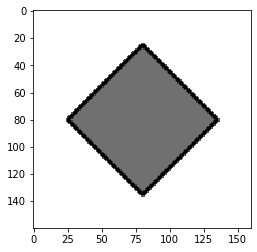

Label: 0


In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:,:].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([32, 16, 160, 160])
Labels batch shape: torch.Size([32])


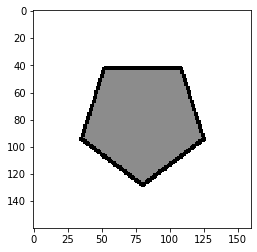

Label: 1


In [15]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:,:].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [16]:
'''
def train_loop(train_dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 128 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
'''

'\ndef train_loop(train_dataloader, model, loss_fn, optimizer):\n    size = len(dataloader.dataset)\n    for batch, (X, y) in enumerate(dataloader):\n        # Compute prediction and loss\n        pred = model(X)\n        loss = loss_fn(pred, y)\n\n        # Backpropagation\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        if batch % 128 == 0:\n            loss, current = loss.item(), batch * len(X)\n            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")\n'

In [17]:
def train_loop(device, epoch, train_loader, model, optimizer):
	model.train()
	# Iterate over batches
	for batch_idx, (X, y) in enumerate(train_loader):
		# Batch start time
		start_time = time.time()
		# Use sequence indices to slice corresponding images
		#x_seq = all_imgs[seq_ind,:,:]
		x_seq = X.float()       
		# Load data to device
		x_seq = x_seq.to(device)
		y = y.to(device)
		# Zero out gradients for optimizer 
		optimizer.zero_grad()
		# Run model 
		'''
		if 'MNM' in args.model_name:
			y_pred_linear, y_pred, const_loss = model(x_seq, device)
		else:
			y_pred_linear, y_pred = model(x_seq, device)
		'''
		y_pred_linear, y_pred = model(x_seq, device)
		# Loss
		loss_fn = nn.CrossEntropyLoss()
		loss = loss_fn(y_pred_linear, y)
		'''
		if 'MNM' in args.model_name:
			loss += const_loss
		'''
		# Update model
		loss.backward()
		optimizer.step()
		# Batch duration
		end_time = time.time()
		batch_dur = end_time - start_time
		# Report prgoress
		#if batch_idx % args.log_interval == 0:
		if batch_idx % 50 == 0:
			# Accuracy
			acc = torch.eq(y_pred, y).float().mean().item() * 100.0
			# Report 	
			log.info('[Epoch: ' + str(epoch) + '] ' + \
					 '[Batch: ' + str(batch_idx) + ' of ' + str(len(train_loader)) + '] ' + \
					 '[Loss = ' + '{:.4f}'.format(loss.item()) + '] ' + \
					 '[Accuracy = ' + '{:.2f}'.format(acc) + '] ' + \
					 '[' + '{:.3f}'.format(batch_dur) + ' sec/batch]')
			# Save progress to file
			'''
			train_prog_f.write(str(batch_idx) + ' ' +\
							   '{:.4f}'.format(loss.item()) + ' ' + \
							   '{:.2f}'.format(acc) + '\n')
			'''

In [18]:
def test_loop_v2(device, epoch, test_loader, model):
	model.eval()
	# Iterate over batches
	for batch_idx, (X, y) in enumerate(test_loader):
		# Batch start time
		start_time = time.time()
		# Use sequence indices to slice corresponding images
		#x_seq = all_imgs[seq_ind,:,:]
		x_seq = X.float()       
		# Load data to device
		x_seq = x_seq.to(device)
		y = y.to(device)
		# Zero out gradients for optimizer 
		optimizer.zero_grad()
		# Run model 
		'''
		if 'MNM' in args.model_name:
			y_pred_linear, y_pred, const_loss = model(x_seq, device)
		else:
			y_pred_linear, y_pred = model(x_seq, device)
		'''
		y_pred_linear, y_pred = model(x_seq, device)
		# Loss
		loss_fn = nn.CrossEntropyLoss()
		loss = loss_fn(y_pred_linear, y)
		'''
		if 'MNM' in args.model_name:
			loss += const_loss
		'''
		# Update model
		loss.backward()
		optimizer.step()
		# Batch duration
		end_time = time.time()
		batch_dur = end_time - start_time
		# Report prgoress
		#if batch_idx % args.log_interval == 0:
		if batch_idx % 10 == 0:
			# Accuracy
			acc = torch.eq(y_pred, y).float().mean().item() * 100.0
			# Report 	
			log.info('[Epoch: ' + str(epoch) + '] ' + \
					 '[Batch: ' + str(batch_idx) + ' of ' + str(len(train_loader)) + '] ' + \
					 '[Loss = ' + '{:.4f}'.format(loss.item()) + '] ' + \
					 '[Accuracy = ' + '{:.2f}'.format(acc) + '] ' + \
					 '[' + '{:.3f}'.format(batch_dur) + ' sec/batch]')
			# Save progress to file
			'''
			train_prog_f.write(str(batch_idx) + ' ' +\
							   '{:.4f}'.format(loss.item()) + ' ' + \
							   '{:.2f}'.format(acc) + '\n')
			'''

In [19]:
def test_loop(device, epoch, test_loader, model):
	log.info('Evaluating on test set...')
	# Set to eval mode
	model.eval()
	# Iterate over batches
	all_acc = []
	all_loss = []
	for batch_idx, (X, y) in enumerate(test_loader):
		# Use sequence indices to slice corresponding images
		x_seq = X.float()
		# Load data to device
		x_seq = x_seq.to(device)
		y = y.to(device)
		# Run model 
		'''
		if 'MNM' in args.model_name:
			y_pred_linear, y_pred, const_loss = model(x_seq, device)
		else:
			y_pred_linear, y_pred = model(x_seq, device)
		'''
		y_pred_linear, y_pred = model(x_seq, device)
		# Loss
		loss_fn = nn.CrossEntropyLoss()
		loss = loss_fn(y_pred_linear, y)
		'''
		if 'MNM' in args.model_name:
			loss += const_loss
		'''
		all_loss.append(loss.item())
		# Accuracy
		acc = torch.eq(y_pred, y).float().mean().item() * 100.0
		all_acc.append(acc)
		# Report progress
		log.info('[Batch: ' + str(batch_idx) + ' of ' + str(len(test_loader)) + ']')
	# Report overall test performance
	avg_loss = np.mean(all_loss)
	avg_acc = np.mean(all_acc)
	log.info('[Summary] ' + \
			 '[Loss = ' + '{:.4f}'.format(avg_loss) + '] ' + \
			 '[Accuracy = ' + '{:.2f}'.format(avg_acc) + ']')

In [20]:
learning_rate = 5e-4
batch_size = 32
epochs = 100
device = torch.device("cuda:" + str(0))
model = Model().to(device)
# Initialize the loss function
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(device, t+1, train_dataloader, model, optimizer)
test_loop(device,t, test_dataloader, model)
print("Done!")

[2021-05-18 16:11:06,927] Building encoder...
[2021-05-18 16:11:06,928] Building convolutional encoder...
[2021-05-18 16:11:06,929] Conv layers...
[2021-05-18 16:11:06,935] FC layers...
[2021-05-18 16:11:07,086] Building LSTM and output layers...


Epoch 1
-------------------------------


[2021-05-18 16:11:09,638] [Epoch: 1] [Batch: 0 of 32] [Loss = 2.0668] [Accuracy = 15.62] [0.164 sec/batch]


Epoch 2
-------------------------------


[2021-05-18 16:11:19,746] [Epoch: 2] [Batch: 0 of 32] [Loss = 2.0836] [Accuracy = 6.25] [0.205 sec/batch]


Epoch 3
-------------------------------


[2021-05-18 16:11:29,921] [Epoch: 3] [Batch: 0 of 32] [Loss = 2.0849] [Accuracy = 12.50] [0.206 sec/batch]


Epoch 4
-------------------------------


[2021-05-18 16:11:40,124] [Epoch: 4] [Batch: 0 of 32] [Loss = 2.0790] [Accuracy = 6.25] [0.206 sec/batch]


Epoch 5
-------------------------------


[2021-05-18 16:11:50,336] [Epoch: 5] [Batch: 0 of 32] [Loss = 2.0847] [Accuracy = 6.25] [0.208 sec/batch]


Epoch 6
-------------------------------


[2021-05-18 16:12:00,585] [Epoch: 6] [Batch: 0 of 32] [Loss = 2.0751] [Accuracy = 18.75] [0.203 sec/batch]


Epoch 7
-------------------------------


[2021-05-18 16:12:10,853] [Epoch: 7] [Batch: 0 of 32] [Loss = 2.0796] [Accuracy = 18.75] [0.208 sec/batch]


Epoch 8
-------------------------------


[2021-05-18 16:12:21,137] [Epoch: 8] [Batch: 0 of 32] [Loss = 2.0811] [Accuracy = 18.75] [0.207 sec/batch]


Epoch 9
-------------------------------


[2021-05-18 16:12:31,425] [Epoch: 9] [Batch: 0 of 32] [Loss = 2.0752] [Accuracy = 6.25] [0.210 sec/batch]


Epoch 10
-------------------------------


[2021-05-18 16:12:41,718] [Epoch: 10] [Batch: 0 of 32] [Loss = 2.0850] [Accuracy = 12.50] [0.210 sec/batch]


Epoch 11
-------------------------------


[2021-05-18 16:12:52,016] [Epoch: 11] [Batch: 0 of 32] [Loss = 2.0781] [Accuracy = 12.50] [0.203 sec/batch]


Epoch 12
-------------------------------


[2021-05-18 16:13:02,346] [Epoch: 12] [Batch: 0 of 32] [Loss = 2.0805] [Accuracy = 9.38] [0.211 sec/batch]


Epoch 13
-------------------------------


[2021-05-18 16:13:12,682] [Epoch: 13] [Batch: 0 of 32] [Loss = 2.0786] [Accuracy = 9.38] [0.209 sec/batch]


Epoch 14
-------------------------------


[2021-05-18 16:13:23,006] [Epoch: 14] [Batch: 0 of 32] [Loss = 2.0804] [Accuracy = 12.50] [0.208 sec/batch]


Epoch 15
-------------------------------


[2021-05-18 16:13:33,346] [Epoch: 15] [Batch: 0 of 32] [Loss = 2.0772] [Accuracy = 21.88] [0.211 sec/batch]


Epoch 16
-------------------------------


[2021-05-18 16:13:43,692] [Epoch: 16] [Batch: 0 of 32] [Loss = 2.0804] [Accuracy = 6.25] [0.206 sec/batch]


Epoch 17
-------------------------------


[2021-05-18 16:13:54,028] [Epoch: 17] [Batch: 0 of 32] [Loss = 2.0819] [Accuracy = 21.88] [0.208 sec/batch]


Epoch 18
-------------------------------


[2021-05-18 16:14:04,390] [Epoch: 18] [Batch: 0 of 32] [Loss = 2.0798] [Accuracy = 9.38] [0.204 sec/batch]


Epoch 19
-------------------------------


[2021-05-18 16:14:14,725] [Epoch: 19] [Batch: 0 of 32] [Loss = 2.0762] [Accuracy = 15.62] [0.209 sec/batch]


Epoch 20
-------------------------------


[2021-05-18 16:14:25,063] [Epoch: 20] [Batch: 0 of 32] [Loss = 2.0694] [Accuracy = 25.00] [0.205 sec/batch]


Epoch 21
-------------------------------


[2021-05-18 16:14:35,414] [Epoch: 21] [Batch: 0 of 32] [Loss = 2.0750] [Accuracy = 18.75] [0.210 sec/batch]


Epoch 22
-------------------------------


[2021-05-18 16:14:45,760] [Epoch: 22] [Batch: 0 of 32] [Loss = 2.0796] [Accuracy = 12.50] [0.209 sec/batch]


Epoch 23
-------------------------------


[2021-05-18 16:14:56,105] [Epoch: 23] [Batch: 0 of 32] [Loss = 2.0771] [Accuracy = 25.00] [0.211 sec/batch]


Epoch 24
-------------------------------


[2021-05-18 16:15:06,434] [Epoch: 24] [Batch: 0 of 32] [Loss = 2.0818] [Accuracy = 12.50] [0.203 sec/batch]


Epoch 25
-------------------------------


[2021-05-18 16:15:16,739] [Epoch: 25] [Batch: 0 of 32] [Loss = 2.0793] [Accuracy = 15.62] [0.204 sec/batch]


Epoch 26
-------------------------------


[2021-05-18 16:15:27,055] [Epoch: 26] [Batch: 0 of 32] [Loss = 2.0859] [Accuracy = 6.25] [0.205 sec/batch]


Epoch 27
-------------------------------


[2021-05-18 16:15:37,389] [Epoch: 27] [Batch: 0 of 32] [Loss = 2.0792] [Accuracy = 12.50] [0.208 sec/batch]


Epoch 28
-------------------------------


[2021-05-18 16:15:47,714] [Epoch: 28] [Batch: 0 of 32] [Loss = 2.0738] [Accuracy = 18.75] [0.203 sec/batch]


Epoch 29
-------------------------------


[2021-05-18 16:15:58,059] [Epoch: 29] [Batch: 0 of 32] [Loss = 2.0783] [Accuracy = 9.38] [0.210 sec/batch]


Epoch 30
-------------------------------


[2021-05-18 16:16:08,384] [Epoch: 30] [Batch: 0 of 32] [Loss = 2.0760] [Accuracy = 15.62] [0.208 sec/batch]


Epoch 31
-------------------------------


[2021-05-18 16:16:18,717] [Epoch: 31] [Batch: 0 of 32] [Loss = 2.0743] [Accuracy = 18.75] [0.203 sec/batch]


Epoch 32
-------------------------------


[2021-05-18 16:16:29,045] [Epoch: 32] [Batch: 0 of 32] [Loss = 2.0845] [Accuracy = 3.12] [0.203 sec/batch]


Epoch 33
-------------------------------


[2021-05-18 16:16:39,333] [Epoch: 33] [Batch: 0 of 32] [Loss = 2.0786] [Accuracy = 9.38] [0.209 sec/batch]


Epoch 34
-------------------------------


[2021-05-18 16:16:49,661] [Epoch: 34] [Batch: 0 of 32] [Loss = 2.0926] [Accuracy = 9.38] [0.203 sec/batch]


Epoch 35
-------------------------------


[2021-05-18 16:17:00,000] [Epoch: 35] [Batch: 0 of 32] [Loss = 2.0772] [Accuracy = 18.75] [0.204 sec/batch]


Epoch 36
-------------------------------


[2021-05-18 16:17:10,321] [Epoch: 36] [Batch: 0 of 32] [Loss = 2.0732] [Accuracy = 18.75] [0.204 sec/batch]


Epoch 37
-------------------------------


[2021-05-18 16:17:20,634] [Epoch: 37] [Batch: 0 of 32] [Loss = 2.0816] [Accuracy = 3.12] [0.204 sec/batch]


Epoch 38
-------------------------------


[2021-05-18 16:17:30,969] [Epoch: 38] [Batch: 0 of 32] [Loss = 2.0775] [Accuracy = 12.50] [0.211 sec/batch]


Epoch 39
-------------------------------


[2021-05-18 16:17:41,328] [Epoch: 39] [Batch: 0 of 32] [Loss = 2.0711] [Accuracy = 15.62] [0.205 sec/batch]


Epoch 40
-------------------------------


[2021-05-18 16:17:51,657] [Epoch: 40] [Batch: 0 of 32] [Loss = 2.0781] [Accuracy = 9.38] [0.208 sec/batch]


Epoch 41
-------------------------------


[2021-05-18 16:18:01,989] [Epoch: 41] [Batch: 0 of 32] [Loss = 2.0753] [Accuracy = 18.75] [0.210 sec/batch]


Epoch 42
-------------------------------


[2021-05-18 16:18:12,334] [Epoch: 42] [Batch: 0 of 32] [Loss = 2.0714] [Accuracy = 25.00] [0.210 sec/batch]


Epoch 43
-------------------------------


[2021-05-18 16:18:22,639] [Epoch: 43] [Batch: 0 of 32] [Loss = 2.0749] [Accuracy = 18.75] [0.210 sec/batch]


Epoch 44
-------------------------------


[2021-05-18 16:18:32,953] [Epoch: 44] [Batch: 0 of 32] [Loss = 2.0974] [Accuracy = 12.50] [0.208 sec/batch]


Epoch 45
-------------------------------


[2021-05-18 16:18:43,272] [Epoch: 45] [Batch: 0 of 32] [Loss = 2.0830] [Accuracy = 9.38] [0.203 sec/batch]


Epoch 46
-------------------------------


[2021-05-18 16:18:53,612] [Epoch: 46] [Batch: 0 of 32] [Loss = 2.0876] [Accuracy = 3.12] [0.203 sec/batch]


Epoch 47
-------------------------------


[2021-05-18 16:19:03,942] [Epoch: 47] [Batch: 0 of 32] [Loss = 2.0832] [Accuracy = 12.50] [0.208 sec/batch]


Epoch 48
-------------------------------


[2021-05-18 16:19:14,266] [Epoch: 48] [Batch: 0 of 32] [Loss = 2.0882] [Accuracy = 9.38] [0.211 sec/batch]


Epoch 49
-------------------------------


[2021-05-18 16:19:24,621] [Epoch: 49] [Batch: 0 of 32] [Loss = 2.0720] [Accuracy = 12.50] [0.203 sec/batch]


Epoch 50
-------------------------------


[2021-05-18 16:19:34,929] [Epoch: 50] [Batch: 0 of 32] [Loss = 2.0755] [Accuracy = 9.38] [0.209 sec/batch]


Epoch 51
-------------------------------


[2021-05-18 16:19:45,261] [Epoch: 51] [Batch: 0 of 32] [Loss = 2.0664] [Accuracy = 18.75] [0.204 sec/batch]


Epoch 52
-------------------------------


[2021-05-18 16:19:55,586] [Epoch: 52] [Batch: 0 of 32] [Loss = 2.0734] [Accuracy = 18.75] [0.210 sec/batch]


Epoch 53
-------------------------------


[2021-05-18 16:20:05,918] [Epoch: 53] [Batch: 0 of 32] [Loss = 2.0761] [Accuracy = 9.38] [0.209 sec/batch]


Epoch 54
-------------------------------


[2021-05-18 16:20:16,234] [Epoch: 54] [Batch: 0 of 32] [Loss = 2.0768] [Accuracy = 15.62] [0.209 sec/batch]


Epoch 55
-------------------------------


[2021-05-18 16:20:26,559] [Epoch: 55] [Batch: 0 of 32] [Loss = 2.0849] [Accuracy = 9.38] [0.205 sec/batch]


Epoch 56
-------------------------------


[2021-05-18 16:20:36,895] [Epoch: 56] [Batch: 0 of 32] [Loss = 2.0805] [Accuracy = 9.38] [0.204 sec/batch]


Epoch 57
-------------------------------


[2021-05-18 16:20:47,259] [Epoch: 57] [Batch: 0 of 32] [Loss = 2.0838] [Accuracy = 3.12] [0.203 sec/batch]


Epoch 58
-------------------------------


[2021-05-18 16:20:57,560] [Epoch: 58] [Batch: 0 of 32] [Loss = 2.0813] [Accuracy = 3.12] [0.210 sec/batch]


Epoch 59
-------------------------------


[2021-05-18 16:21:07,871] [Epoch: 59] [Batch: 0 of 32] [Loss = 2.0771] [Accuracy = 18.75] [0.210 sec/batch]


Epoch 60
-------------------------------


[2021-05-18 16:21:18,175] [Epoch: 60] [Batch: 0 of 32] [Loss = 2.0938] [Accuracy = 6.25] [0.208 sec/batch]


Epoch 61
-------------------------------


[2021-05-18 16:21:28,497] [Epoch: 61] [Batch: 0 of 32] [Loss = 2.0811] [Accuracy = 6.25] [0.210 sec/batch]


Epoch 62
-------------------------------


[2021-05-18 16:21:38,817] [Epoch: 62] [Batch: 0 of 32] [Loss = 2.0729] [Accuracy = 9.38] [0.208 sec/batch]


Epoch 63
-------------------------------


[2021-05-18 16:21:49,139] [Epoch: 63] [Batch: 0 of 32] [Loss = 2.0667] [Accuracy = 15.62] [0.210 sec/batch]


Epoch 64
-------------------------------


[2021-05-18 16:21:59,460] [Epoch: 64] [Batch: 0 of 32] [Loss = 2.0753] [Accuracy = 9.38] [0.211 sec/batch]


Epoch 65
-------------------------------


[2021-05-18 16:22:09,802] [Epoch: 65] [Batch: 0 of 32] [Loss = 2.0871] [Accuracy = 3.12] [0.208 sec/batch]


Epoch 66
-------------------------------


[2021-05-18 16:22:20,154] [Epoch: 66] [Batch: 0 of 32] [Loss = 2.0758] [Accuracy = 12.50] [0.207 sec/batch]


Epoch 67
-------------------------------


[2021-05-18 16:22:30,480] [Epoch: 67] [Batch: 0 of 32] [Loss = 2.0808] [Accuracy = 6.25] [0.208 sec/batch]


Epoch 68
-------------------------------


[2021-05-18 16:22:40,790] [Epoch: 68] [Batch: 0 of 32] [Loss = 2.0773] [Accuracy = 15.62] [0.203 sec/batch]


Epoch 69
-------------------------------


[2021-05-18 16:22:51,085] [Epoch: 69] [Batch: 0 of 32] [Loss = 2.0900] [Accuracy = 18.75] [0.205 sec/batch]


Epoch 70
-------------------------------


[2021-05-18 16:23:01,395] [Epoch: 70] [Batch: 0 of 32] [Loss = 2.0669] [Accuracy = 15.62] [0.204 sec/batch]


Epoch 71
-------------------------------


[2021-05-18 16:23:11,677] [Epoch: 71] [Batch: 0 of 32] [Loss = 2.0610] [Accuracy = 21.88] [0.204 sec/batch]


Epoch 72
-------------------------------


[2021-05-18 16:23:21,966] [Epoch: 72] [Batch: 0 of 32] [Loss = 2.0853] [Accuracy = 6.25] [0.206 sec/batch]


Epoch 73
-------------------------------


[2021-05-18 16:23:32,268] [Epoch: 73] [Batch: 0 of 32] [Loss = 2.0939] [Accuracy = 18.75] [0.202 sec/batch]


Epoch 74
-------------------------------


[2021-05-18 16:23:42,563] [Epoch: 74] [Batch: 0 of 32] [Loss = 2.0738] [Accuracy = 9.38] [0.202 sec/batch]


Epoch 75
-------------------------------


[2021-05-18 16:23:52,888] [Epoch: 75] [Batch: 0 of 32] [Loss = 2.0952] [Accuracy = 3.12] [0.210 sec/batch]


Epoch 76
-------------------------------


[2021-05-18 16:24:03,210] [Epoch: 76] [Batch: 0 of 32] [Loss = 2.0627] [Accuracy = 15.62] [0.205 sec/batch]


Epoch 77
-------------------------------


[2021-05-18 16:24:13,538] [Epoch: 77] [Batch: 0 of 32] [Loss = 2.0750] [Accuracy = 21.88] [0.209 sec/batch]


Epoch 78
-------------------------------


[2021-05-18 16:24:23,846] [Epoch: 78] [Batch: 0 of 32] [Loss = 2.0668] [Accuracy = 12.50] [0.207 sec/batch]


Epoch 79
-------------------------------


[2021-05-18 16:24:34,188] [Epoch: 79] [Batch: 0 of 32] [Loss = 2.0771] [Accuracy = 9.38] [0.209 sec/batch]


Epoch 80
-------------------------------


[2021-05-18 16:24:44,469] [Epoch: 80] [Batch: 0 of 32] [Loss = 2.0749] [Accuracy = 18.75] [0.209 sec/batch]


Epoch 81
-------------------------------


[2021-05-18 16:24:54,781] [Epoch: 81] [Batch: 0 of 32] [Loss = 2.0615] [Accuracy = 21.88] [0.204 sec/batch]


Epoch 82
-------------------------------


[2021-05-18 16:25:05,088] [Epoch: 82] [Batch: 0 of 32] [Loss = 2.0758] [Accuracy = 12.50] [0.210 sec/batch]


Epoch 83
-------------------------------


[2021-05-18 16:25:15,402] [Epoch: 83] [Batch: 0 of 32] [Loss = 2.0749] [Accuracy = 6.25] [0.210 sec/batch]


Epoch 84
-------------------------------


[2021-05-18 16:25:25,740] [Epoch: 84] [Batch: 0 of 32] [Loss = 2.0952] [Accuracy = 9.38] [0.205 sec/batch]


Epoch 85
-------------------------------


[2021-05-18 16:25:36,055] [Epoch: 85] [Batch: 0 of 32] [Loss = 2.0907] [Accuracy = 9.38] [0.208 sec/batch]


Epoch 86
-------------------------------


[2021-05-18 16:25:46,378] [Epoch: 86] [Batch: 0 of 32] [Loss = 2.0724] [Accuracy = 15.62] [0.209 sec/batch]


Epoch 87
-------------------------------


[2021-05-18 16:25:56,722] [Epoch: 87] [Batch: 0 of 32] [Loss = 2.0659] [Accuracy = 28.12] [0.210 sec/batch]


Epoch 88
-------------------------------


[2021-05-18 16:26:07,057] [Epoch: 88] [Batch: 0 of 32] [Loss = 2.0749] [Accuracy = 21.88] [0.205 sec/batch]


Epoch 89
-------------------------------


[2021-05-18 16:26:17,417] [Epoch: 89] [Batch: 0 of 32] [Loss = 2.0939] [Accuracy = 6.25] [0.204 sec/batch]


Epoch 90
-------------------------------


[2021-05-18 16:26:27,738] [Epoch: 90] [Batch: 0 of 32] [Loss = 2.0665] [Accuracy = 15.62] [0.210 sec/batch]


Epoch 91
-------------------------------


[2021-05-18 16:26:38,050] [Epoch: 91] [Batch: 0 of 32] [Loss = 2.0826] [Accuracy = 18.75] [0.205 sec/batch]


Epoch 92
-------------------------------


[2021-05-18 16:26:48,373] [Epoch: 92] [Batch: 0 of 32] [Loss = 2.0657] [Accuracy = 28.12] [0.203 sec/batch]


Epoch 93
-------------------------------


[2021-05-18 16:26:58,694] [Epoch: 93] [Batch: 0 of 32] [Loss = 2.0835] [Accuracy = 9.38] [0.210 sec/batch]


Epoch 94
-------------------------------


[2021-05-18 16:27:09,014] [Epoch: 94] [Batch: 0 of 32] [Loss = 2.0700] [Accuracy = 28.12] [0.204 sec/batch]


Epoch 95
-------------------------------


[2021-05-18 16:27:19,330] [Epoch: 95] [Batch: 0 of 32] [Loss = 2.0996] [Accuracy = 0.00] [0.204 sec/batch]


Epoch 96
-------------------------------


[2021-05-18 16:27:29,677] [Epoch: 96] [Batch: 0 of 32] [Loss = 2.0790] [Accuracy = 31.25] [0.203 sec/batch]


Epoch 97
-------------------------------


[2021-05-18 16:27:39,998] [Epoch: 97] [Batch: 0 of 32] [Loss = 2.0701] [Accuracy = 15.62] [0.204 sec/batch]


Epoch 98
-------------------------------


[2021-05-18 16:27:50,345] [Epoch: 98] [Batch: 0 of 32] [Loss = 2.0892] [Accuracy = 12.50] [0.209 sec/batch]


Epoch 99
-------------------------------


[2021-05-18 16:28:00,684] [Epoch: 99] [Batch: 0 of 32] [Loss = 2.0749] [Accuracy = 21.88] [0.211 sec/batch]


Epoch 100
-------------------------------


[2021-05-18 16:28:10,984] [Epoch: 100] [Batch: 0 of 32] [Loss = 2.0758] [Accuracy = 15.62] [0.204 sec/batch]
[2021-05-18 16:28:20,927] Evaluating on test set...
[2021-05-18 16:28:21,112] [Batch: 0 of 13]
[2021-05-18 16:28:21,241] [Batch: 1 of 13]
[2021-05-18 16:28:21,369] [Batch: 2 of 13]
[2021-05-18 16:28:21,496] [Batch: 3 of 13]
[2021-05-18 16:28:21,623] [Batch: 4 of 13]
[2021-05-18 16:28:21,748] [Batch: 5 of 13]
[2021-05-18 16:28:21,875] [Batch: 6 of 13]
[2021-05-18 16:28:22,002] [Batch: 7 of 13]
[2021-05-18 16:28:22,128] [Batch: 8 of 13]
[2021-05-18 16:28:22,258] [Batch: 9 of 13]
[2021-05-18 16:28:22,384] [Batch: 10 of 13]
[2021-05-18 16:28:22,511] [Batch: 11 of 13]
[2021-05-18 16:28:22,580] [Batch: 12 of 13]
[2021-05-18 16:28:22,580] [Summary] [Loss = 2.0854] [Accuracy = 12.26]


Done!
